# Classification model using Pytorch

In [711]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split

### Dataset

In [712]:
sample_count = 1000

X, y = make_circles(sample_count, noise=0.03, random_state=21)
X.shape, y.shape

((1000, 2), (1000,))

In [713]:
X[:5], y[:5]

(array([[ 1.00783787, -0.13224763],
        [ 0.07620797, -1.01482893],
        [-0.17014712, -0.78291748],
        [-0.40372338, -0.69918955],
        [ 0.21830748,  0.77590142]]),
 array([0, 0, 1, 1, 1]))

In [714]:
# convert into DataFrame
circles_df = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "label": y})

In [715]:
circles_df.head(5)

,X1,X2,label
0,1.007838,-0.132248,0
1,0.076208,-1.014829,0
2,-0.170147,-0.782917,1
3,-0.403723,-0.699190,1
4,0.218307,0.775901,1


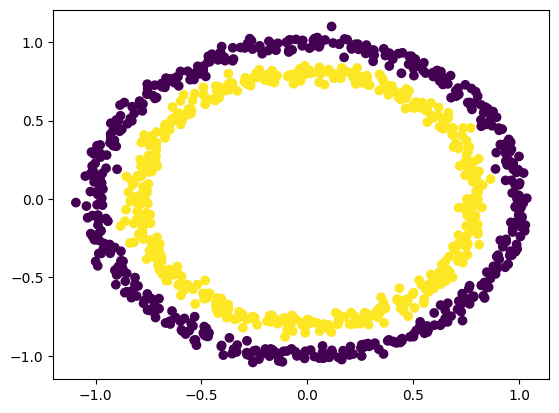

In [716]:
# Visualize the set as a plot
plt.scatter(circles_df["X1"], circles_df["X2"], c=circles_df["label"])

## Split and transform into tensors

In [717]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [718]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:3], y[:3]

(tensor([[ 1.0078, -0.1322],
         [ 0.0762, -1.0148],
         [-0.1701, -0.7829]]),
 tensor([0., 0., 1.]))

In [719]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [720]:
# Split for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [721]:
len(X_train), len(X_test)

(800, 200)

# Build the classification model

In [722]:
# device agnostic code - in order to run GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [723]:
# Create the model class
# -> this is a linear model example - not fir for our problem (missing non-lin activation functions)
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2, out_features=10, device=device) # input layer, match the input shape
        self.linear_layer2 = nn.Linear(in_features=10, out_features=10, device=device)
        self.linear_layer3 = nn.Linear(in_features=10, out_features=10, device=device)
        self.linear_layer_out = nn.Linear(in_features=10, out_features=1, device=device) # out layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_out(self.linear_layer3(self.linear_layer2(self.linear_layer1(x)))) # x -> layer 1 -> layer 2 -> out

In [724]:
# Alternate way of writing a multi-layer network - similar to the one above
circle_model_alternate = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

circle_model_alternate

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

In [725]:
# circle_model = ClassificationModel().to(device)
circle_model = circle_model_alternate
circle_model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

In [726]:
# Check the kind of device it is running on
next(circle_model.parameters()).device

device(type='cuda', index=0)

In [727]:
# Model parameters
loss_function = nn.BCEWithLogitsLoss() # also applies Sigmoid activation function
optimizer = torch.optim.Adam(params=circle_model.parameters(), lr=0.01)

In [728]:
# Compute accuracy function
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training loop



* **logits** = raw model output without passing through an activation function
* Converting raw **logits** -> prediction probabilities -> prediction labels
* We can convert them by passing them through an activation function (e.g. sigmoid, softmax)
* Convert model predictions to pred labels by taking the `argmax()`

In [729]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [730]:
epochs = 1000

for epoch in range(epochs):
    circle_model.train()

    # Converting raw logits -> prediction probabilities -> prediction labels
    y_logits = circle_model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_function(y_logits, y_train)
    acc = accuracy_function(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    circle_model.eval()
    with torch.inference_mode():
        test_logits = circle_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_function(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.72204 | Acc: 48.88 | Test loss: 0.69304 | Test acc: 54.50
Epoch: 10 | Loss: 0.69284 | Acc: 54.87 | Test loss: 0.69433 | Test acc: 45.50
Epoch: 20 | Loss: 0.69262 | Acc: 51.12 | Test loss: 0.69839 | Test acc: 45.50
Epoch: 30 | Loss: 0.69041 | Acc: 51.12 | Test loss: 0.69191 | Test acc: 47.00
Epoch: 40 | Loss: 0.68531 | Acc: 65.62 | Test loss: 0.68419 | Test acc: 68.50
Epoch: 50 | Loss: 0.66432 | Acc: 76.00 | Test loss: 0.66412 | Test acc: 77.50
Epoch: 60 | Loss: 0.60141 | Acc: 81.25 | Test loss: 0.60960 | Test acc: 77.00
Epoch: 70 | Loss: 0.46133 | Acc: 88.88 | Test loss: 0.45766 | Test acc: 89.50
Epoch: 80 | Loss: 0.24236 | Acc: 97.50 | Test loss: 0.24625 | Test acc: 96.50
Epoch: 90 | Loss: 0.11659 | Acc: 98.38 | Test loss: 0.12434 | Test acc: 98.00
Epoch: 100 | Loss: 0.05726 | Acc: 99.12 | Test loss: 0.07545 | Test acc: 98.00
Epoch: 110 | Loss: 0.03563 | Acc: 99.38 | Test loss: 0.05763 | Test acc: 98.00
Epoch: 120 | Loss: 0.02554 | Acc: 99.38 | Test loss: 0.04806 | 

### Make predictions

In [731]:
import requests
from pathlib import Path

# Get some pre-written vis functions
if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

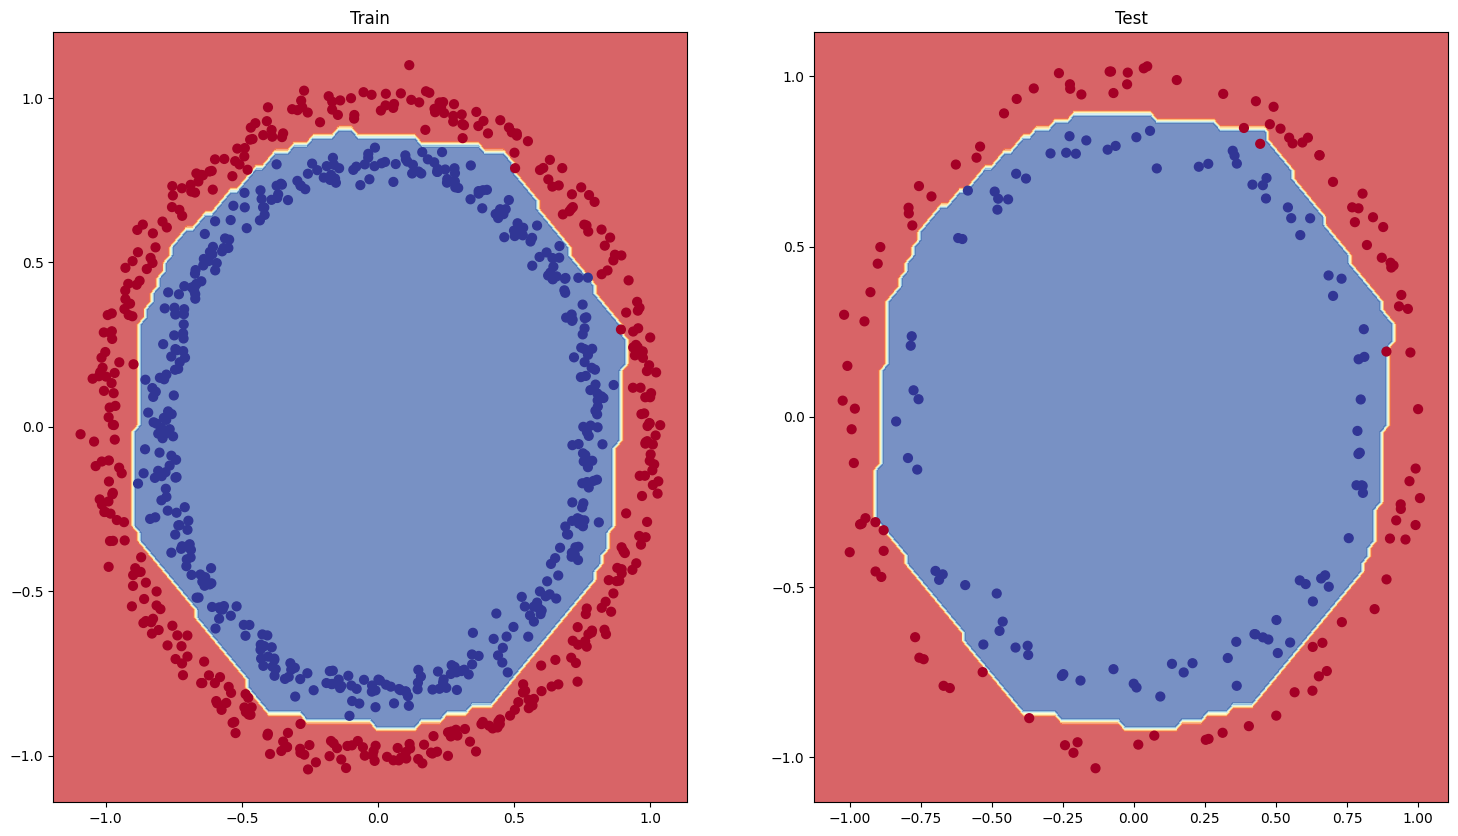

In [732]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model, X_test, y_test)

# Replicating non-linear activation function
Deep dive into non-linear activation functions - how do they work

In [733]:
# create data
tensor = torch.arange(-10, 10, 1, dtype=torch.float32)
tensor.dtype

torch.float32

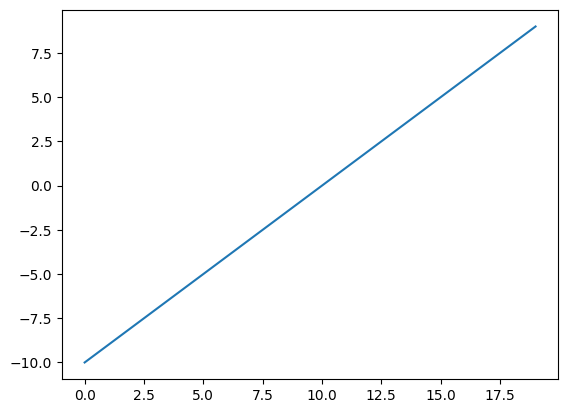

In [734]:
plt.plot(tensor)

In [735]:
# replicate the ReLU function
# it basically computes the maximum between an element and 0 -> so we have only positive values
def homebrew_relu(data: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), data)

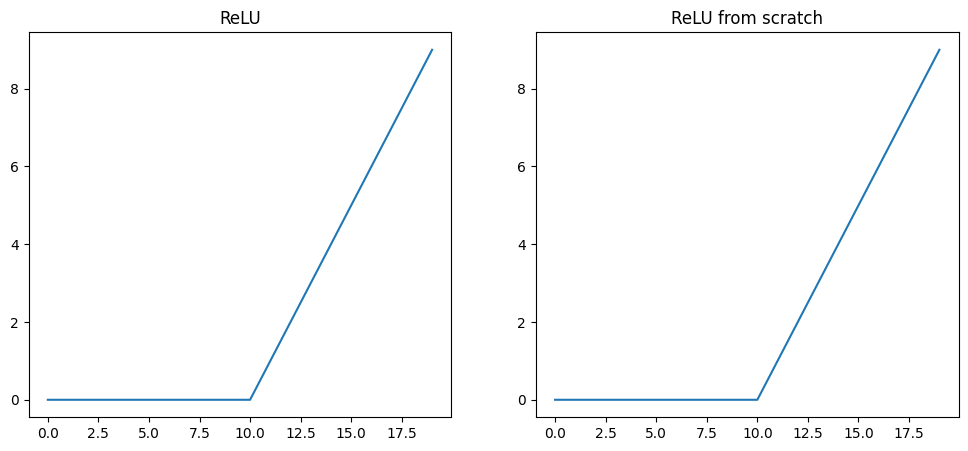

In [736]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("ReLU")
plt.plot(torch.relu(tensor))
plt.subplot(1, 2, 2)
plt.title("ReLU from scratch")
plt.plot(homebrew_relu(tensor))

In [737]:
# create Sigmoid in the same way
def homebrew_sigmoid(data: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.special.expit(-data))

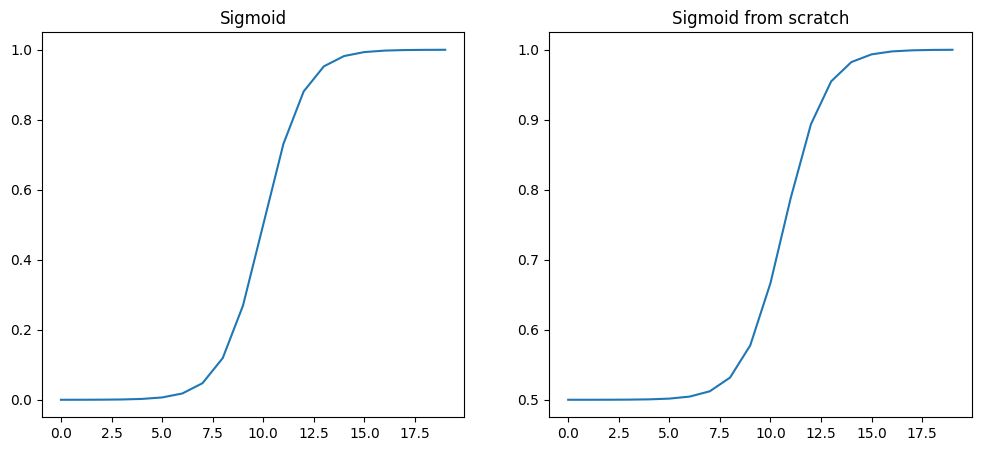

In [738]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Sigmoid")
plt.plot(torch.sigmoid(tensor))
plt.subplot(1, 2, 2)
plt.title("Sigmoid from scratch")
plt.plot(homebrew_sigmoid(tensor))

#Multi-class classification

### Build the dataset

In [739]:
# hyperparameter setting - for dataset
X_blobs, y_blobs = make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=1.5)

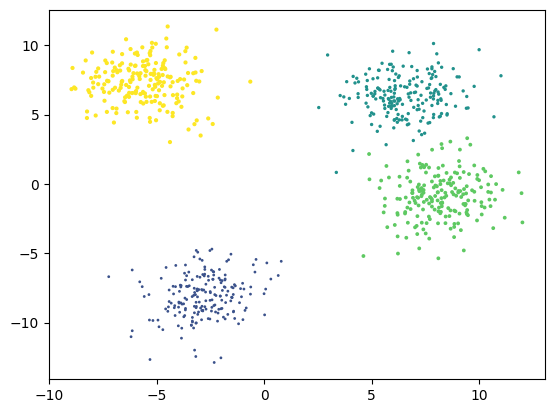

In [740]:
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], y_blobs, c=y_blobs)

In [741]:
# Convert to tensors
X_blobs = torch.from_numpy(X_blobs).type(torch.float)
y_blobs = torch.from_numpy(y_blobs).type(torch.LongTensor)

In [742]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blobs, y_blobs, test_size=0.2, random_state=21)
len(X_blob_train), len(X_blob_test)

(800, 200)

In [743]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

### Build the model

In [744]:
class BlobModel(nn.Module):
    def __init__(self, input_features=2, output_features=5, hidden_units=10):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [745]:
multiclass_model = BlobModel(2, 5, 10).to(device)
multiclass_model

BlobModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
)

In [746]:
loss_fct = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=multiclass_model.parameters(), lr=0.01)

### Model prediction logic:
logits from model -> prediction probs (with `softmax`) -> prediction labels (with `argmax` to get the index of max probability label)

In [747]:
# Training loop
epochs = 1000

for epoch in range(epochs):
    multiclass_model.train()

    logits = multiclass_model(X_blob_train)
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    loss = loss_fct(logits, y_blob_train)
    acc = accuracy_function(y_true=y_blob_train, y_pred=preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    multiclass_model.eval()
    with torch.inference_mode():
        test_logits = multiclass_model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fct(test_logits, y_blob_test)
        test_acc = accuracy_function(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.69401 | Acc: 31.75 | Test loss: 1.52502 | Test acc: 37.50
Epoch: 10 | Loss: 0.74108 | Acc: 78.50 | Test loss: 0.63452 | Test acc: 84.00
Epoch: 20 | Loss: 0.33019 | Acc: 92.38 | Test loss: 0.26359 | Test acc: 94.50
Epoch: 30 | Loss: 0.19560 | Acc: 94.12 | Test loss: 0.14562 | Test acc: 95.00
Epoch: 40 | Loss: 0.16801 | Acc: 93.88 | Test loss: 0.11137 | Test acc: 95.00
Epoch: 50 | Loss: 0.16056 | Acc: 94.00 | Test loss: 0.10460 | Test acc: 95.00
Epoch: 60 | Loss: 0.15467 | Acc: 94.50 | Test loss: 0.10451 | Test acc: 95.00
Epoch: 70 | Loss: 0.15182 | Acc: 94.50 | Test loss: 0.10356 | Test acc: 95.00
Epoch: 80 | Loss: 0.14914 | Acc: 94.50 | Test loss: 0.10002 | Test acc: 95.00
Epoch: 90 | Loss: 0.14691 | Acc: 94.38 | Test loss: 0.09770 | Test acc: 95.00
Epoch: 100 | Loss: 0.14453 | Acc: 94.50 | Test loss: 0.09641 | Test acc: 95.00
Epoch: 110 | Loss: 0.14248 | Acc: 94.50 | Test loss: 0.09522 | Test acc: 95.00
Epoch: 120 | Loss: 0.14064 | Acc: 94.50 | Test loss: 0.09354 | 

### Make preds and evaluate the model

In [748]:
with torch.inference_mode():
    test_logits = multiclass_model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
test_preds[:10]

tensor([3, 4, 0, 2, 3, 3, 2, 1, 1, 1], device='cuda:0')

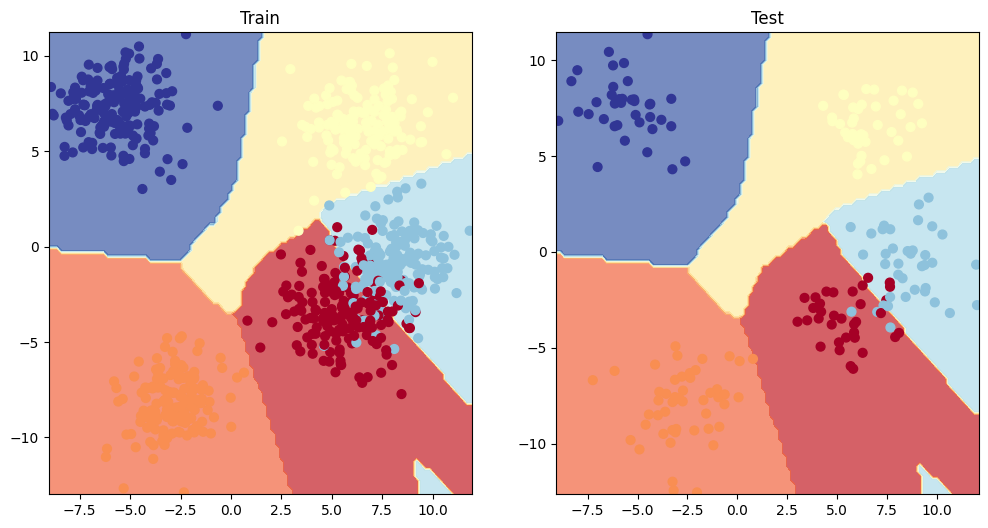

In [749]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(multiclass_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(multiclass_model, X_blob_test, y_blob_test)

### More on evaluation metrics
* Accuracy
* Precision
* Recall
* F1 score
* Confusion matrix
* Classification report
Good to aceess multiple eval metrics -> `TorchMetrics`

In [755]:
from torchmetrics import Accuracy

In [758]:
torchmetric_acc = Accuracy(task="multiclass", num_classes=5).to(device)

torchmetric_acc(test_preds, y_blob_test)

tensor(0.9600, device='cuda:0')